# Forest Data

In [1]:
#load the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
import seaborn as sns
from keras.layers import Input, Dense, concatenate, Dropout, Conv1D, MaxPooling1D
from keras.models import Model
from keras.utils import to_categorical
import tensorflow.keras as keras


Using TensorFlow backend.


In [2]:
np.set_printoptions(suppress = True)

## Load the dataset

In [3]:
#load path here where the datasets reside
path = '/home/brett/Documents/Datasets/ten-datasets/'

#load the dataset into a dataframe
df_forestdata = pd.read_csv(path + 'Forest.csv')

In [4]:
#labels are in the last column, features are in the other columns
Y = df_forestdata.iloc[:,54]
X = df_forestdata.iloc[:,0:54]

In [5]:
#create 80/20 train/test split in the data using sklearn
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size =0.2, random_state = 123, stratify=Y)
#create binary labels for MLPs
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [6]:
#the following function gives some default classification metrics that can be re-used
def model_fit_report(model,x_values,y_values_actual,y_values_predicted,y_values_probability,labels,DataSetType):
    print("Model Fit Results")
    print("")
    print (DataSetType + " Accuracy: %0.3f" % accuracy_score(y_values_actual,y_values_predicted))
    print("")
    
        
    matrix = confusion_matrix(y_values_actual, y_values_predicted,labels)#labels=lb.classes_
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(labels))+0.5,labels)
    plt.ylabel('True label')
    plt.yticks(np.arange(len(labels))+0.5,labels)
    plt.show()

    #print("Confusion Matrix")
    #CM = plot_confusion_matrix(model,x_values,y_values_actual,values_format = 'n')
    #print (CM)
    #print("")
    #print (confusion_matrix(y_values_actual,y_values_predicted))
    #print("")
    print("Classification Report")
    print("")
    print (classification_report(y_values_actual,y_values_predicted))
    
  
    

In [7]:
#standardise the data
mms = MinMaxScaler()
x_train_scaled = mms.fit_transform(x_train)
x_test_scaled = mms.fit_transform(x_test)

## Logistic Regression

Model Fit Results

Train Accuracy: 0.634



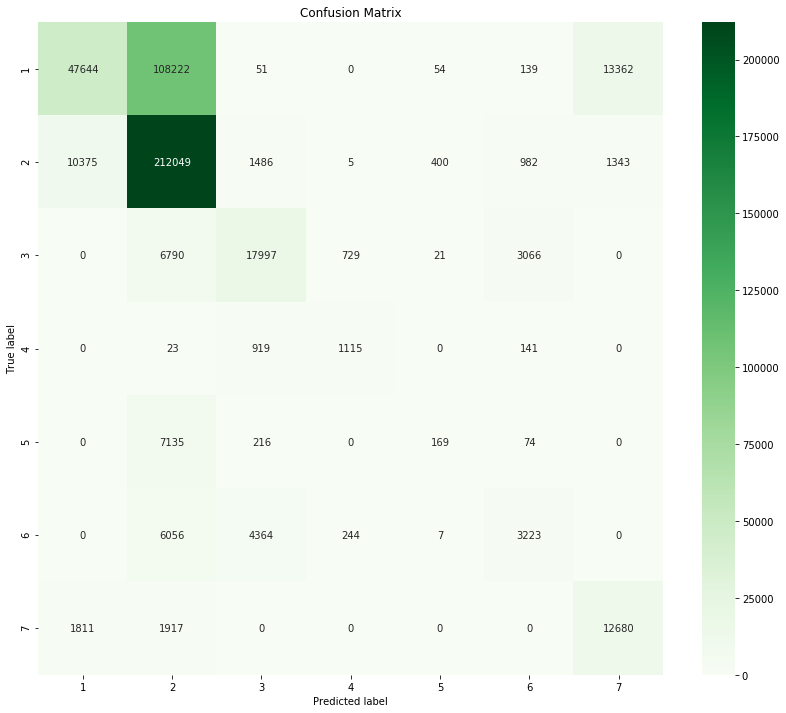

Classification Report

              precision    recall  f1-score   support

           1       0.80      0.28      0.42    169472
           2       0.62      0.94      0.75    226640
           3       0.72      0.63      0.67     28603
           4       0.53      0.51      0.52      2198
           5       0.26      0.02      0.04      7594
           6       0.42      0.23      0.30     13894
           7       0.46      0.77      0.58     16408

    accuracy                           0.63    464809
   macro avg       0.54      0.48      0.47    464809
weighted avg       0.67      0.63      0.59    464809

Model Fit Results

Test Accuracy: 0.633



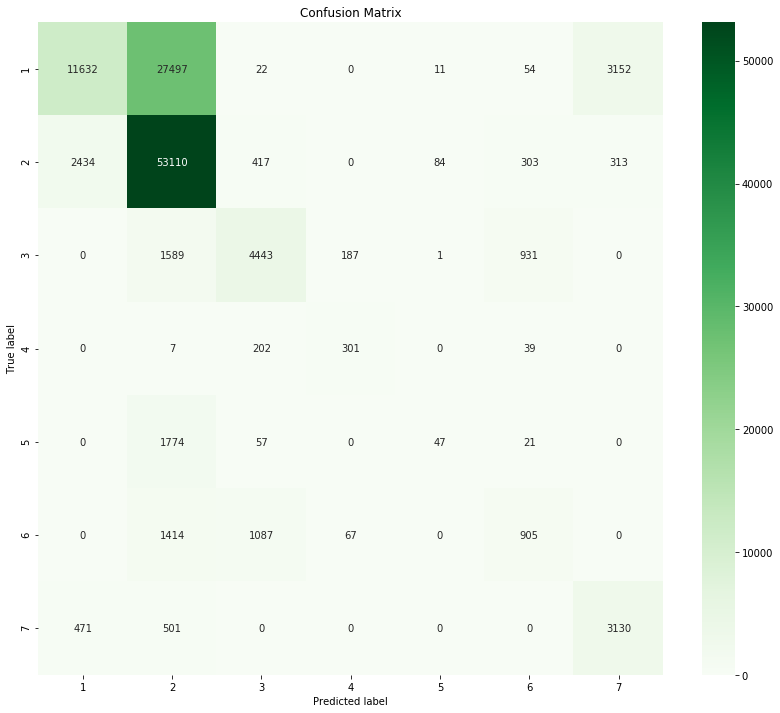

Classification Report

              precision    recall  f1-score   support

           1       0.80      0.27      0.41     42368
           2       0.62      0.94      0.75     56661
           3       0.71      0.62      0.66      7151
           4       0.54      0.55      0.55       549
           5       0.33      0.02      0.05      1899
           6       0.40      0.26      0.32      3473
           7       0.47      0.76      0.59      4102

    accuracy                           0.63    116203
   macro avg       0.55      0.49      0.47    116203
weighted avg       0.67      0.63      0.59    116203



In [23]:
#start with a default logistic regression with no regularisation (C=100)

lr = LogisticRegression(C=100,max_iter = 100, tol=.1,solver='sag')
lr.fit(x_train_scaled,y_train)


#need to add 1 to the assigned class, otherwise the classes start from zero which isn't correct.
y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled),np.unique(y_train),'Train')

#get results for test dataset
y_test_predict = lr.predict_proba(x_test_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_test_scaled,y_test,y_test_predict,lr.predict_proba(x_test_scaled),np.unique(y_train),'Test')

### Optimising Regularisation ('C')

In [24]:
#define the values of C to test and then use validation_curve from sklearn to evaluate
parameter_range = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(estimator = lr, X=x_train_scaled, y=y_train, param_name ='C',param_range=parameter_range,cv=10)

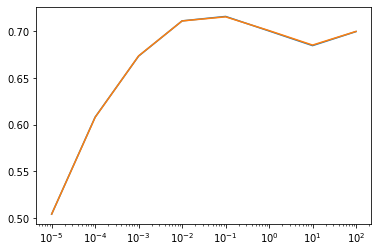

In [25]:

#obtain the mean results from the samples
train_mean = np.mean(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)

#plot the results
plt.plot(parameter_range,train_mean)
plt.plot(parameter_range,test_mean)
plt.xscale('log')

Not sure why the training results decrease in line with validation results. Was expecting train results to get
better with increasing C (ie training should overfit)

0.1
Model Fit Results

Train Accuracy: 0.682



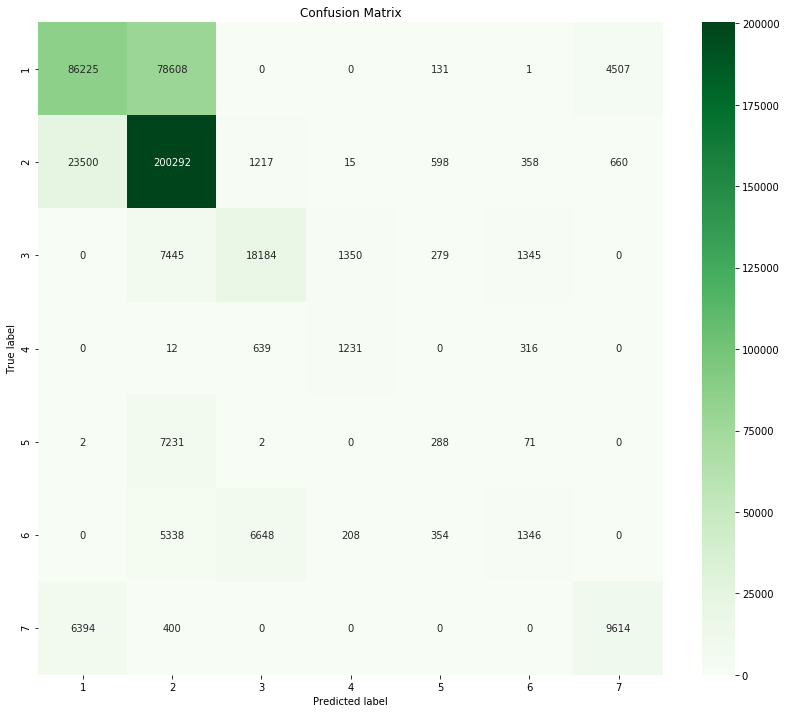

Classification Report

              precision    recall  f1-score   support

           1       0.74      0.51      0.60    169472
           2       0.67      0.88      0.76    226640
           3       0.68      0.64      0.66     28603
           4       0.44      0.56      0.49      2198
           5       0.17      0.04      0.06      7594
           6       0.39      0.10      0.16     13894
           7       0.65      0.59      0.62     16408

    accuracy                           0.68    464809
   macro avg       0.54      0.47      0.48    464809
weighted avg       0.68      0.68      0.66    464809

Model Fit Results

Test Accuracy: 0.680



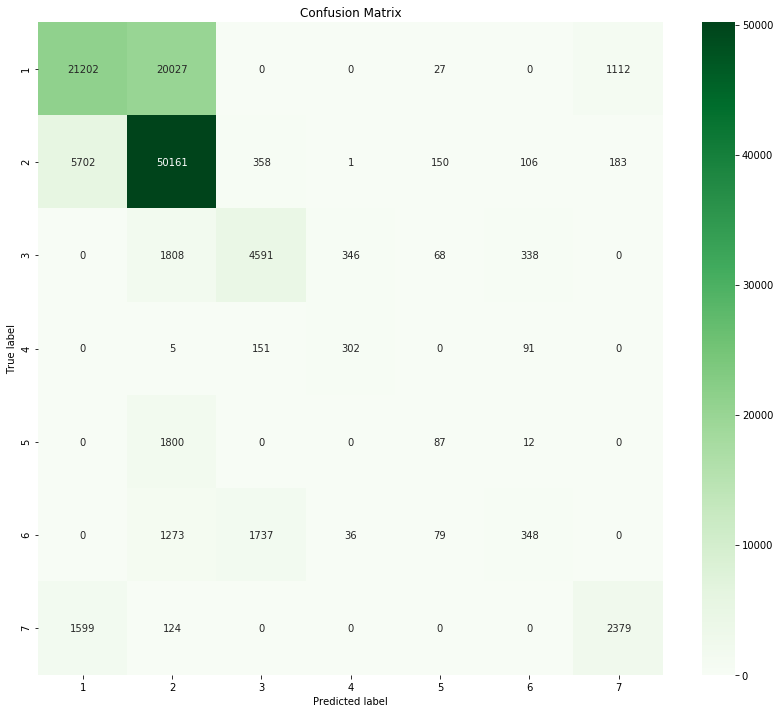

Classification Report

              precision    recall  f1-score   support

           1       0.74      0.50      0.60     42368
           2       0.67      0.89      0.76     56661
           3       0.67      0.64      0.66      7151
           4       0.44      0.55      0.49       549
           5       0.21      0.05      0.08      1899
           6       0.39      0.10      0.16      3473
           7       0.65      0.58      0.61      4102

    accuracy                           0.68    116203
   macro avg       0.54      0.47      0.48    116203
weighted avg       0.68      0.68      0.66    116203



In [26]:
#find the test value with highest accuracy score and corresponding parameter as the optimal C value
optimal_C = parameter_range[test_mean.argmax()]
print(optimal_C)
#and then use that in the final logistic regression
lr = LogisticRegression(C=optimal_C,max_iter = 100, tol=1,solver='sag')
lr.fit(x_train_scaled,y_train)
#need to add 1 to the assigned class, otherwise the classes start from zero which isn't correct.
y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled),np.unique(y_train),'Train')
#get results for test dataset
y_test_predict = lr.predict_proba(x_test_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_test_scaled,y_test,y_test_predict,lr.predict_proba(x_test_scaled),np.unique(y_train),'Test')

## Logistc Regression with PCA

In [34]:
#get the principal components from the scaled data and use that in the logistic regression
from sklearn.decomposition import PCA
pca = PCA(n_components = 12,random_state = 123) #n_components is estimated from commented out section below
x_train_pca = pca.fit_transform(x_train_scaled)
lr = LogisticRegression(C=.001,max_iter = 100, tol=.1,solver='sag')
lr.fit(x_train_pca,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.1, verbose=0,
                   warm_start=False)

Model Fit Results

Train Accuracy: 0.634



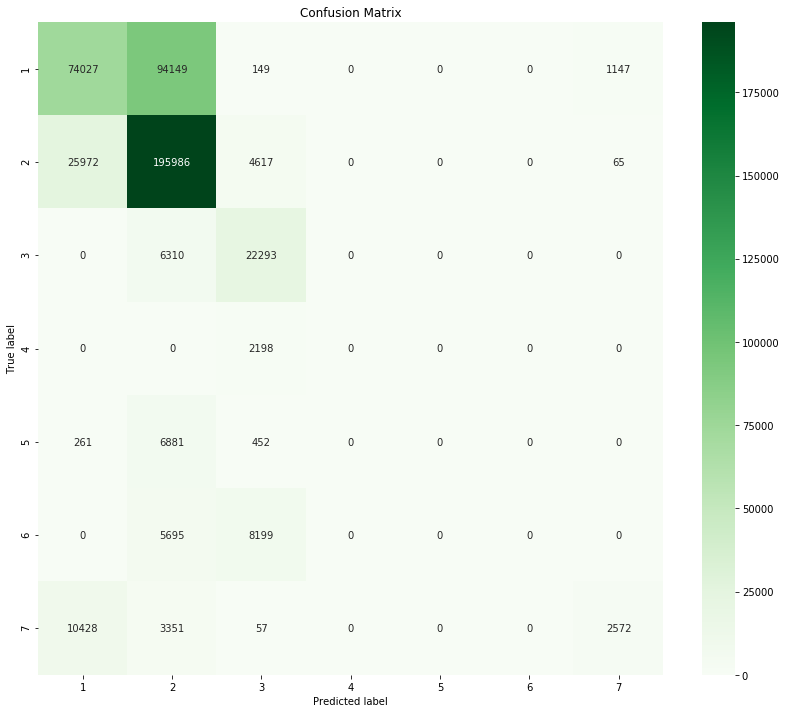

Classification Report



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.67      0.44      0.53    169472
           2       0.63      0.86      0.73    226640
           3       0.59      0.78      0.67     28603
           4       0.00      0.00      0.00      2198
           5       0.00      0.00      0.00      7594
           6       0.00      0.00      0.00     13894
           7       0.68      0.16      0.25     16408

    accuracy                           0.63    464809
   macro avg       0.37      0.32      0.31    464809
weighted avg       0.61      0.63      0.60    464809

Model Fit Results

Test Accuracy: 0.630



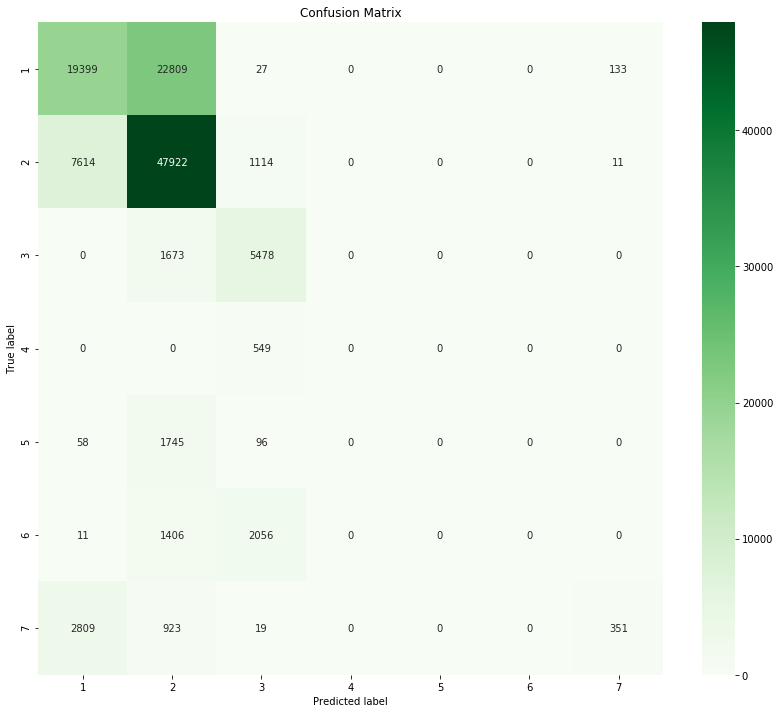

Classification Report

              precision    recall  f1-score   support

           1       0.65      0.46      0.54     42368
           2       0.63      0.85      0.72     56661
           3       0.59      0.77      0.66      7151
           4       0.00      0.00      0.00       549
           5       0.00      0.00      0.00      1899
           6       0.00      0.00      0.00      3473
           7       0.71      0.09      0.15      4102

    accuracy                           0.63    116203
   macro avg       0.37      0.31      0.30    116203
weighted avg       0.60      0.63      0.59    116203



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
#get results for training dataset
y_train_predict = lr.predict_proba(x_train_pca).argmax(axis = 1)+1
model_fit_report(lr,x_train_pca,y_train,y_train_predict,lr.predict_proba(x_train_pca),np.unique(y_train),'Train')

#get results for test dataset
x_test_pca = pca.fit_transform(x_test_scaled)
y_test_predict = lr.predict_proba(x_test_pca).argmax(axis = 1)+1
model_fit_report(lr,x_test_pca,y_test,y_test_predict,lr.predict_proba(x_test_pca),np.unique(y_train),'Test')



Results using PCA appear worse than using all features. 

In [ ]:
#The following is useful to get an idea of how many principle components might be appropriate

#pca = PCA(n_components = None)
#x_train_pca = pca.fit_transform(x_train_scaled)
#print(pca.explained_variance_ratio_)

## Random Forest

Model Fit Results

Train Accuracy: 0.687



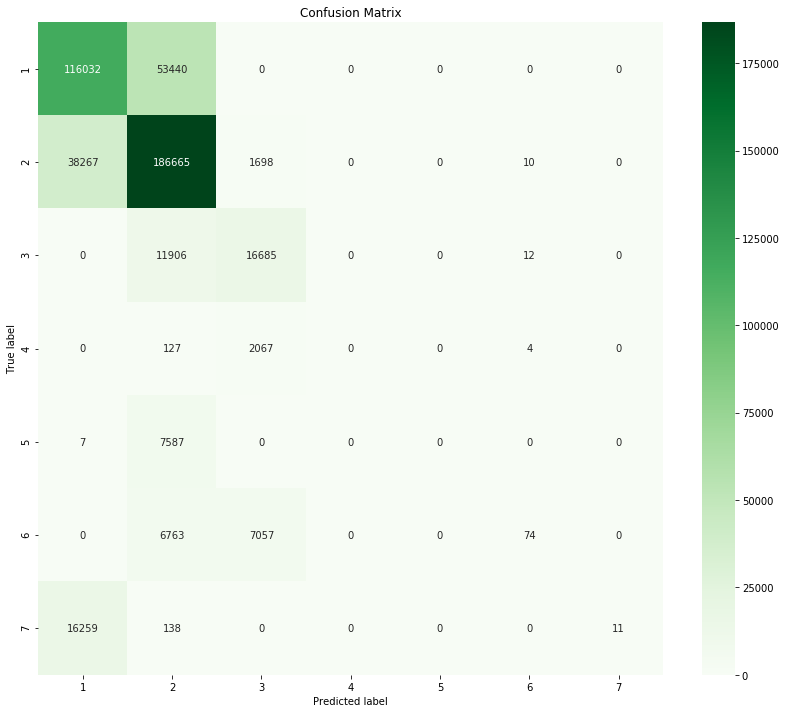

Classification Report



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      0.68      0.68    169472
           2       0.70      0.82      0.76    226640
           3       0.61      0.58      0.59     28603
           4       0.00      0.00      0.00      2198
           5       0.00      0.00      0.00      7594
           6       0.74      0.01      0.01     13894
           7       1.00      0.00      0.00     16408

    accuracy                           0.69    464809
   macro avg       0.53      0.30      0.29    464809
weighted avg       0.68      0.69      0.65    464809

Model Fit Results

Test Accuracy: 0.687



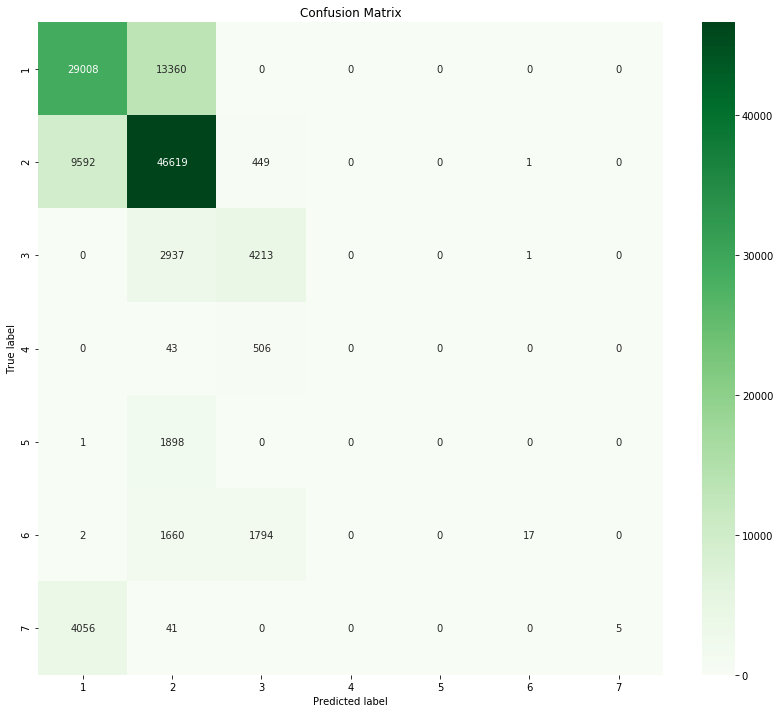

Classification Report

              precision    recall  f1-score   support

           1       0.68      0.68      0.68     42368
           2       0.70      0.82      0.76     56661
           3       0.61      0.59      0.60      7151
           4       0.00      0.00      0.00       549
           5       0.00      0.00      0.00      1899
           6       0.89      0.00      0.01      3473
           7       1.00      0.00      0.00      4102

    accuracy                           0.69    116203
   macro avg       0.55      0.30      0.29    116203
weighted avg       0.69      0.69      0.65    116203



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.1745429 , 0.06531176, 0.05701175, 0.06772851, 0.07137672,
       0.08133137, 0.0591524 , 0.06709973, 0.06382969, 0.06918463,
       0.01334535, 0.00601251, 0.01139442, 0.03384872, 0.00113357,
       0.0079507 , 0.00152233, 0.01328764, 0.00159064, 0.00300518,
       0.00000079, 0.0000333 , 0.        , 0.01433316, 0.00376979,
       0.00801614, 0.00231948, 0.00065449, 0.        , 0.00130981,
       0.00211056, 0.00016778, 0.00045558, 0.00381902, 0.00017344,
       0.01379442, 0.01358916, 0.00433118, 0.00001528, 0.00019648,
       0.00019336, 0.00015238, 0.01006369, 0.00560973, 0.00441555,
       0.00616252, 0.00702682, 0.00073789, 0.00146056, 0.00020807,
       0.        , 0.00957465, 0.01007452, 0.0055699 ])

In [38]:
#setup and train the forest. The n_estimators of 100 is determined from the optimisation below
forest = RandomForestClassifier(criterion='gini', n_estimators = 100, random_state =123,max_samples =100)
forest.fit(x_train,y_train)

#get the training results
y_train_predict = forest.predict(x_train)
model_fit_report(forest,x_train,y_train,y_train_predict,forest.predict_proba(x_train_scaled),np.unique(y_train),'Train')

#get the test results
y_test_predict = forest.predict(x_test)
model_fit_report(forest,x_test,y_test,y_test_predict,forest.predict_proba(x_test),np.unique(y_train),'Test')

#just for interest, understand what features are dominating
importances = forest.feature_importances_
importances


### Optimise the number of trees (n_estimators)

In [39]:
parameter_range = [10,25,50,75,100,150]
train_scores, test_scores = validation_curve(estimator = forest, X=x_train, y=y_train, param_name ='n_estimators',param_range=parameter_range,cv=10)

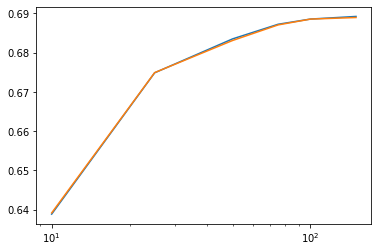

In [40]:
train_mean = np.mean(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
plt.plot(parameter_range,train_mean)
plt.plot(parameter_range,test_mean)
plt.xscale('log')


### SVM

process takes very long time to train (hours)!! Too long to run. Can only train on about 20,000 samples

In [31]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear',C=1.0, random_state=1, probability = True )
svm.fit(x_train_scaled[0:20000],y_train[0:20000])


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

SVM Train Accuracy: 0.111
Model Fit Results

Accuracy: 0.111



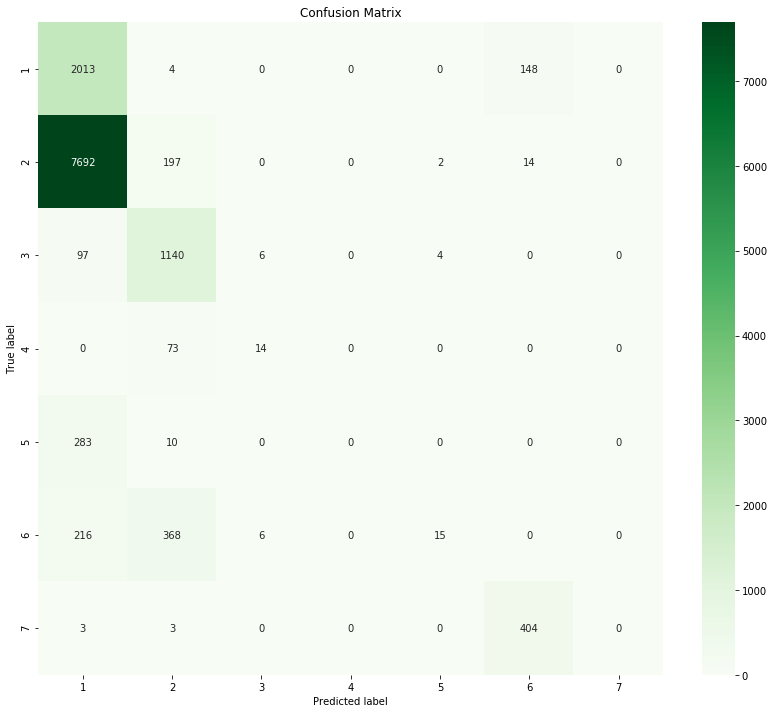

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.20      0.27      0.23      7377
           2       0.11      0.02      0.03      9653
           3       0.23      0.00      0.01      1247
           4       0.00      0.00      0.00        87
           5       0.00      0.00      0.00       295
           6       0.00      0.00      0.00       605
           7       0.00      0.00      0.00       736

    accuracy                           0.11     20000
   macro avg       0.07      0.04      0.03     20000
weighted avg       0.14      0.11      0.10     20000



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Test Accuracy: 0.109
Model Fit Results

Accuracy: 0.109



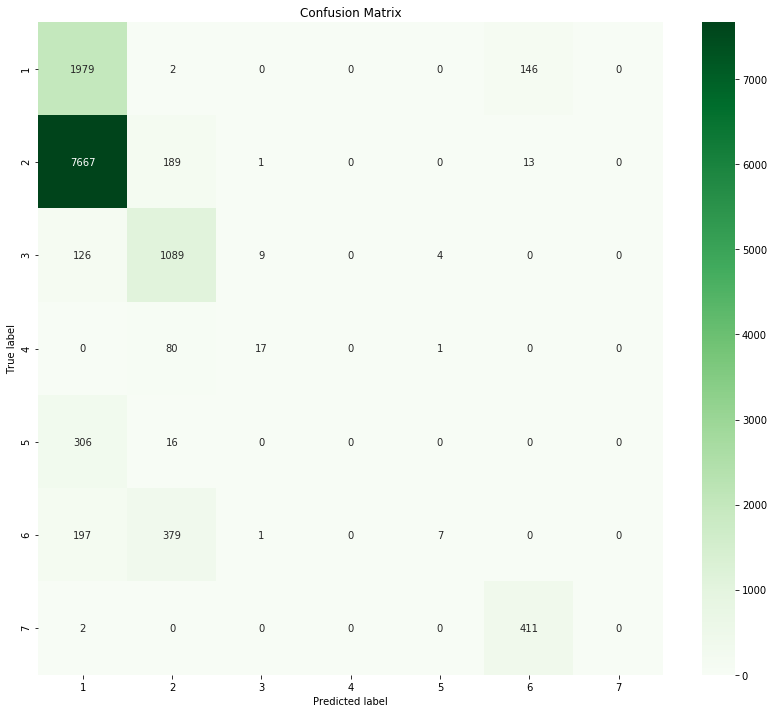

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.19      0.27      0.22      7346
           2       0.11      0.02      0.03      9666
           3       0.32      0.01      0.01      1228
           4       0.00      0.00      0.00        98
           5       0.00      0.00      0.00       323
           6       0.00      0.00      0.00       584
           7       0.00      0.00      0.00       755

    accuracy                           0.11     20000
   macro avg       0.08      0.04      0.03     20000
weighted avg       0.14      0.11      0.10     20000



/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brett/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
y_train_predict = svm.predict_proba(x_train_scaled[0:20000]).argmax(axis = 1)
print ("SVM Train Accuracy: %.3f" % accuracy_score(y_train[0:20000],y_train_predict))
model_fit_report(svm,x_train_scaled[0:20000],y_train[0:20000],y_train_predict,
                 svm.predict_proba(x_train_scaled[0:1]),np.unique(y_train))
                                                                                               
y_test_predict = svm.predict_proba(x_test_scaled[0:20000]).argmax(axis = 1)
print ("SVM Test Accuracy: %.3f" % accuracy_score(y_test[0:20000],y_test_predict))
model_fit_report(svm,x_test_scaled[0:20000],y_test[0:20000],y_test_predict,
                 svm.predict_proba(x_test_scaled[0:1]),np.unique(y_test))



### MLP with Keras

In [18]:
#standard parameters for the various NN architectures
epochs = 10
batch_size = 64

### Two Layer, 100 Unit MLP

In [29]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))



model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))

#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 16,408
Trainable params: 16,408
Non-trainable params: 0
_________________________________________________________________
Train on 464809 samples, validate on 116203 samples
Epoch 1/10
464809/464809 [==============================] - 49s 10

### Two Layer, 200 Unit MLP

In [46]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 200, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 200, 
        input_dim = 200,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=200,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))


model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               11000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1608      
Total params: 52,808
Trainable params: 52,808
Non-trainable params: 0
_________________________________________________________________
Train on 464809 samples, validate on 116203 samples
Epoch 1/10
464809/464809 [==============================] - 63s 

### Two Layer, 300 Unit MLP

In [47]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 300, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 300, 
        input_dim = 300,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=300,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))


model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               16500     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2408      
Total params: 109,208
Trainable params: 109,208
Non-trainable params: 0
_________________________________________________________________
Train on 464809 samples, validate on 116203 samples
Epoch 1/10
464809/464809 [==============================] - 13

### Three Layer, 100 Unit MLP

In [48]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))

model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))

#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               5500      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                

### Four Layer, 100 unit MLP

In [25]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))



model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

### Deep and Shallow MLP
Using functional model

In [28]:
%%time


input_data = Input(shape=x_train_scaled.shape[1:])

#deep stream
deep_dense1 = Dense(100, activation='relu')(input_data)
deep_drop1 = Dropout(0.25)(deep_dense1)
deep_dense2 = Dense(100, activation='relu')(deep_drop1)
deep_drop2 = Dropout(0.25)(deep_dense2)
deep_dense3 = Dense(100, activation='relu')(deep_drop2)
deep_drop3 = Dropout(0.25)(deep_dense3)
deep_dense4 = Dense(100, activation='relu')(deep_dense3)
deep_drop4 = Dropout(0.25)(deep_dense4)

#shallow stream
shallow_dense1 = Dense(300, activation='relu')(input_data)
shallow_drop1 = Dropout(0.25)(shallow_dense1)
shallow_dense2 = Dense(300, activation='relu')(shallow_drop1)
shallow_drop2 = Dropout(0.25)(shallow_dense2)

combined = concatenate([deep_drop4,shallow_drop2])


#result
result = Dense(y_train_binary.shape[1], activation='softmax')(combined)

# this model maps an input to its reconstruction
MLP = Model(input_data, result)


MLP.summary()


# compile model
MLP.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


hist = MLP.fit(x_train_scaled,y_train_binary,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_scaled,y_test_binary))

#encode_imgs_train = enc.predict(train_images) 
#encode_imgs_test = enc.predict(test_images) 

#decode_imgs_train = autoencoder.predict(train_images) 
#decode_imgs_test = autoencoder.predict(test_images) 

#print(encode_imgs_test.shape)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 100)          5500        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 100)          0           dense_35[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 100)          10100       dropout_31[0][0]                 
____________________________________________________________________________________________

### 1D CNN

In [11]:
x_train_scaled.shape

(464809, 54)

In [12]:
x_train_scaled = x_train_scaled[:, :, np.newaxis]
x_test_scaled = x_test_scaled[:, :, np.newaxis]

print(x_train_scaled.shape)
print(x_test_scaled.shape)


(464809, 54, 1)

(116203, 54, 1)

In [14]:
x_train_scaled.shape[1:]

(54, 1)

In [15]:
y_test = np.array(y_test)

In [16]:
y_train

535880    1
176049    1
322055    2
143859    1
568085    2
         ..
116444    1
186891    2
170470    2
522001    7
163318    2
Name: Cover_Type, Length: 464809, dtype: int64

In [9]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Input, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Dense

In [39]:
x_train_scaled.shape

(464809, 54, 1)

In [21]:
CNN = Sequential()


CNN.add(Conv1D(20, 5, activation='relu', input_shape=x_train_scaled.shape[1:], strides=1))
CNN.add(Conv1D(20, 5))
CNN.add(MaxPooling1D(pool_size=3))
CNN.add(Dropout(0.25))

CNN.add(Flatten())


CNN.add(Dense(512, activation='relu'))

CNN.add(Dense(8, activation='softmax'))
CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    

CNN.summary()

#history = model.fit(x_train_scaled,y_train,batch_size=batch_size,epochs =2, verbose =1)
history = CNN.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =10, verbose =1,
              validation_data=(x_test_scaled,y_test_binary))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 50, 20)            120       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 46, 20)            2020      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 20)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 20)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               154112    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                